# Pre-processing of Hepatocytes Data

- Reference: https://www.nature.com/articles/nature21065
- Data (`table_s1_reform.txt`) downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84498
- The log-transformed and scaled data is stored within a `tmp_dir` for subsequent analysis
    - `x_data.npy`: the landmark genes
    - `y_data.npy`: all variable genes under consideration
    - `obs_info.npy`: meta information of each cell
    - `var_info.npy`: meta information of each gene/variable

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
from IPython.display import display
import sys
sys.path.insert(0,'../src')
mpl.rcParams['figure.dpi']= 100

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import scanpy.api as sc
import time
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 


## Gene expression data - supposed already background removed

We work with adata after transform filter (with fewer genes and variance stablizing transformation):
- `load_hepatocyte_data()` parses the raw data file, and
- `transform_filter_anndata()` performs the transformation

The second function optionally regress out the effect of the cell size for all the values in the data matrix.

The scaled and normalized data will be saved in directories: 
 - `{dat_dir}/analysis_on_scaled/data`, and 
 - `{dat_dir}/analysis_on_scaled_size_norm/dat` respectively.

In [3]:
from plot_utils import plot_scatter_discrete, plot_scatter_continuous
from liver_info import get_known_liver_markers
from liver_info import load_hepatocyte_data, transform_filter_anndata
from sim_utils import scale_corr_input, batch_comp_dist_corr
from graph_utils import laplacian_score, construct_kernal_graph
from liver_info import save_processed_data, save_x_y_data

sample_name = "hepatocyte"
lm_genes = get_known_liver_markers()["zonation"]
dat_dir = "/share/PI/sabatti/sc_data/liver2k"
figdir = "/share/PI/sabatti/sc_data/liver2k/figures/{}".format(sample_name)

def scale_data_and_save(adata, lm_genes, tmp_dir, dat_dir):
    gene_scores = {"mean": adata.X.mean(axis=0), 
                   "std": adata.X.std(axis=0),
                   "npc": np.sum(adata.X > 0, axis=0)
                  }
    gene_scores = pd.DataFrame(gene_scores, index=adata.var.index)
    gene_scores = adata.var.join(gene_scores, how="left")
    
    x = adata[:,lm_genes].X
    y = adata.X
    save_processed_data(tmp_dir, x, y, adata.obs, gene_scores)
    
    x_scaled = scale_corr_input(x)
    y_scaled = scale_corr_input(y)
    save_x_y_data(tmp_dir, x_scaled, y_scaled, "scaled")
    
    lm_log_expr = pd.DataFrame(adata[:, lm_genes].X, columns=lm_genes)
    plot_graph_w_ground_truth(lm_log_expr, dat_dir)
    
def plot_gene_mean_std(log_gene_df):
    sns.jointplot(x="mean", y="std", 
                  data=log_gene_df,
                  height=4.5,
                  joint_kws={"s": 1}, 
                  marginal_kws=dict(bins=100, rug=True));
    # std filter results (log2 scale sweep)
    sweeps = [0.05, 0.1, 0.15, 0.2]
    num_genes = log_gene_df.shape[0]
    for sweep in sweeps:
        num_kept = log_gene_df.loc[log_gene_df["std"] > sweep].shape[0]
        print("Kept {} / {} genes with log filter at {}".format(
            num_kept, num_genes, sweep))

def plot_graph_w_ground_truth(lm_df, dat_dir):
    from liver_info import load_zonation_result
    from graph_utils import construct_kernal_graph, construct_knn_naive
    graph_in_dat = (lm_df - lm_df.mean()) / lm_df.std() # center and scale the zonation genes
    graph_in_dat["zone"] = load_zonation_result(dat_dir)
    graph_in_dat = graph_in_dat.sort_values(by="zone")
    kern_graph = construct_kernal_graph(graph_in_dat[lm_genes].values)
    knn_graph = construct_knn_naive(graph_in_dat[lm_genes].values)
    fig, ax = plt.subplots(1,2,figsize=(13,5))
    sns.heatmap(kern_graph.toarray(), xticklabels=False, yticklabels=False, ax=ax[0])
    sns.heatmap(knn_graph.toarray(), xticklabels=False, yticklabels=False, ax=ax[1])
    plt.show()

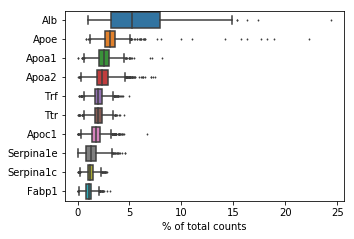

filtered out 16998 genes that are detected in less than 10 cells


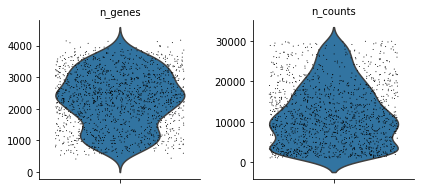

Filtered out: 16998 genes; remaining 10299
Filtered out: 0 doublet cells
View of AnnData object with n_obs × n_vars = 1415 × 10299 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'


Trying to set attribute `.obs` of view, making a copy.


Keeping 8883 / 10299 genes with log1p and std > 0.1
Log-transformed anndata
Saved: x (1415, 6) and y (1415, 8883) at /share/PI/sabatti/sc_data/liver2k/analysis_on_data_original/data
Saved: x (1415, 6) and y (1415, 8883) at /share/PI/sabatti/sc_data/liver2k/analysis_on_data_original/data
       n_genes      n_counts
Cell1     1779   6726.214844
Cell2     3387  20066.574219
Cell3     2791  16297.222656
Cell4     2377  13083.556641
Cell5     2931  18036.222656
                                  gene_ids  n_cells      mean       std  npc
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770  0.487967  0.527124  770
0610007L01Rik                0610007L01Rik      761  0.455494  0.506628  761
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  0.030682  0.159816   65
0610007P14Rik                0610007P14Rik      749  0.456374  0.518156  749
0610007P22Rik                0610007P22Rik       35  0.015438  0.107326   35
Saved: x (1415, 6) and y (1415, 8883) at /share/PI/sabatti/sc_data/liver2k/a

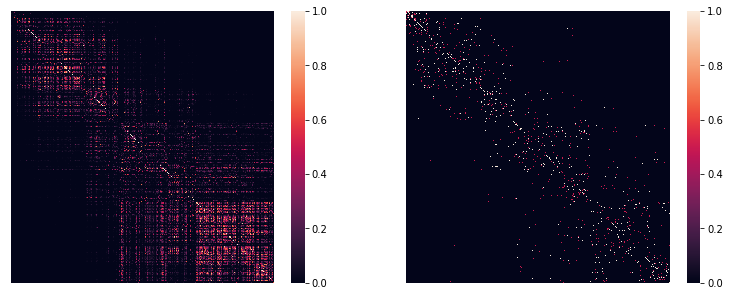

In [4]:
scale_pfx = "original"
adata = load_hepatocyte_data(dat_dir, verbose=True)
adata, log_gene_df = transform_filter_anndata(adata, scale_pfx=scale_pfx)
tmp_dir = os.path.join(dat_dir, "analysis_on_data_{}".format(scale_pfx))
scale_data_and_save(adata, lm_genes, tmp_dir, dat_dir)

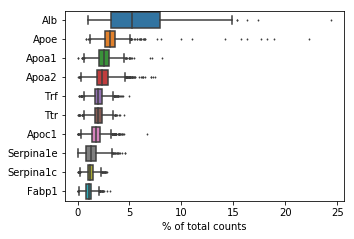

filtered out 16998 genes that are detected in less than 10 cells


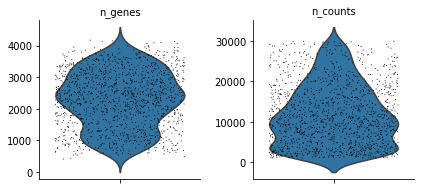

Filtered out: 16998 genes; remaining 10299


Trying to set attribute `.obs` of view, making a copy.


Filtered out: 0 doublet cells
View of AnnData object with n_obs × n_vars = 1415 × 10299 
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells'
Keeping 8883 / 10299 genes with log1p and std > 0.1
Log-transformed anndata
Regressing out size effects from anndata
regressing out ['n_counts']
    finished (0:00:27.58)
Saved: x (1415, 6) and y (1415, 8883) at /share/PI/sabatti/sc_data/liver2k/analysis_on_data_size_norm/data
Saved: x (1415, 6) and y (1415, 8883) at /share/PI/sabatti/sc_data/liver2k/analysis_on_data_size_norm/data
       n_genes      n_counts
Cell1     1779   6726.214844
Cell2     3387  20066.574219
Cell3     2791  16297.222656
Cell4     2377  13083.556641
Cell5     2931  18036.222656
                                  gene_ids  n_cells          mean       std  \
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770 -2.695899e-09  0.517354   
0610007L01Rik                0610007L01Rik      761 -1.010962e-09  0.502673   
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  

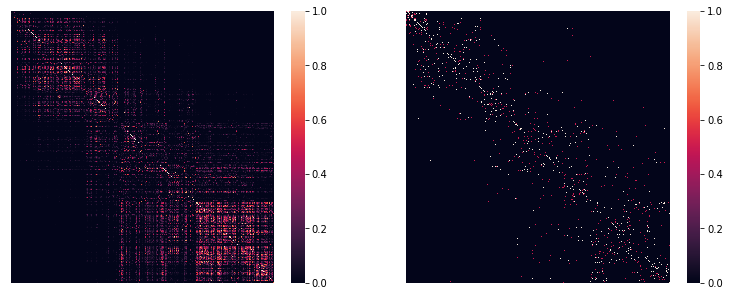

In [5]:
# optional: cell size normalized procedure - not used since down stream results do not change much
scale_pfx = "size_norm"
adata = load_hepatocyte_data(dat_dir, verbose=True)
adata, log_gene_df = transform_filter_anndata(adata, scale_pfx=scale_pfx)
tmp_dir = os.path.join(dat_dir, "analysis_on_data_{}".format(scale_pfx))
scale_data_and_save(adata, lm_genes, tmp_dir, dat_dir)

Kept 10215 / 10299 genes with log filter at 0.05
Kept 8883 / 10299 genes with log filter at 0.1
Kept 7398 / 10299 genes with log filter at 0.15
Kept 6156 / 10299 genes with log filter at 0.2


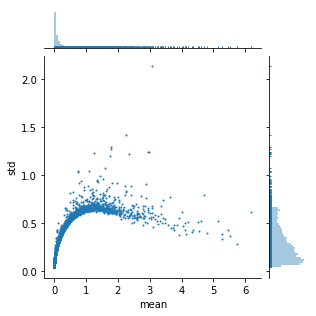

In [15]:
plot_gene_mean_std(log_gene_df)        

## Test for loading the processed data

In [6]:
from liver_info import load_x_y_data
x, y, obs_df, var_df = load_x_y_data(tmp_dir, center=True, scale=True)

Data directory: /share/PI/sabatti/sc_data/liver2k/analysis_on_data_size_norm/data
Loaded data: x (1415, 6) and y (1415, 8883)


# OLD STUFF

## For testing only - remove the following stats later

In [21]:
display(gene_scores.sort_values(by="lap_score").head(10))
display(gene_scores.sort_values(by="dist_corr", ascending=False).head(10))

,gene_ids,n_cells,mean,std,npc,dist_corr,lap_score
Cyp2f2,Cyp2f2,1235,2.269190,1.415569,1235,0.596100,0.088669
Cyp2e1,Cyp2e1,1221,3.086100,2.132811,1221,0.638385,0.108277
Alb,Alb,1415,6.190163,0.610225,1415,0.594513,0.226166
Cyp2c29;Cyp2c53-ps,Cyp2c29;Cyp2c53-ps,876,1.253551,1.231416,876,0.531624,0.253444
Aldh3a2,Aldh3a2,901,1.086136,1.036856,901,0.520298,0.267996
Cyp1a2,Cyp1a2,1144,1.778516,1.274644,1144,0.521438,0.325154
Ass1,Ass1,1411,3.164296,0.588850,1411,0.475740,0.410142
Cyp2a5,Cyp2a5,625,0.747768,1.031232,625,0.438497,0.431627
Glul,Glul,523,0.347392,0.661617,523,0.391287,0.445638
Asl,Asl,1397,2.707551,0.570133,1397,0.444801,0.459454


,gene_ids,n_cells,mean,std,npc,dist_corr,lap_score
Cyp2e1,Cyp2e1,1221,3.086100,2.132811,1221,0.638385,0.108277
Cyp2f2,Cyp2f2,1235,2.269190,1.415569,1235,0.596100,0.088669
Alb,Alb,1415,6.190163,0.610225,1415,0.594513,0.226166
Cyp2c29;Cyp2c53-ps,Cyp2c29;Cyp2c53-ps,876,1.253551,1.231416,876,0.531624,0.253444
Cyp1a2,Cyp1a2,1144,1.778516,1.274644,1144,0.521438,0.325154
Aldh3a2,Aldh3a2,901,1.086136,1.036856,901,0.520298,0.267996
Ass1,Ass1,1411,3.164296,0.588850,1411,0.475740,0.410142
Csad,Csad,1119,1.338918,0.943950,1119,0.451324,0.468054
Hsd17b13,Hsd17b13,994,1.049970,0.887261,994,0.451065,0.509553
Asl,Asl,1397,2.707551,0.570133,1397,0.444801,0.459454


## What do we learn from the 6 landmark genes?

- some zones simply do not express certain genes - sparsity arises for biological reasons
- we do not see perfect linear relationships - sparsity and noise are technicial effects 
- there is a reason that Glul is corrupted (too many zeros due to capture inefficiency)
- these reasons indicate that we might be better off also looking into other genes that can help improve the structure

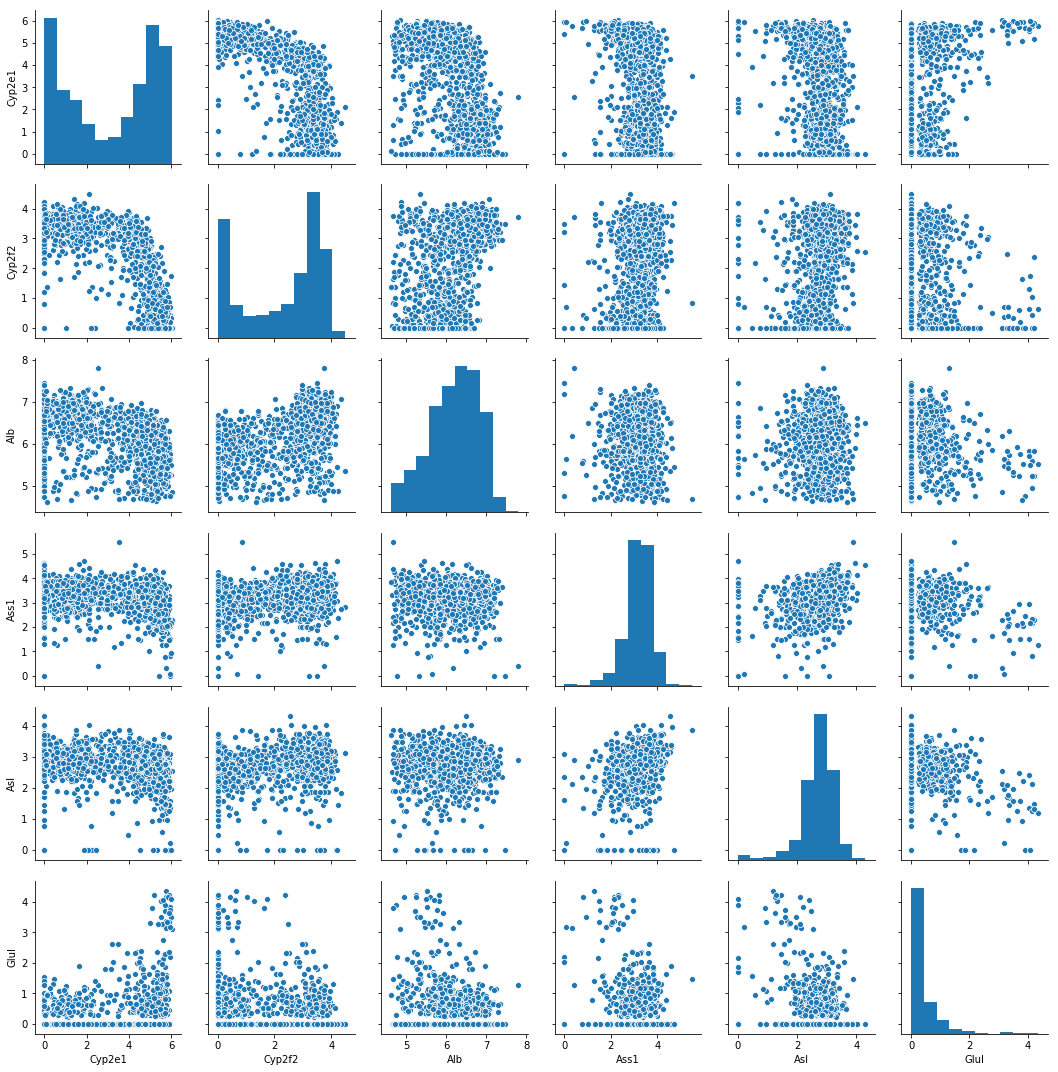

In [25]:
sns.pairplot(lm_log_expr, vars=lm_genes)

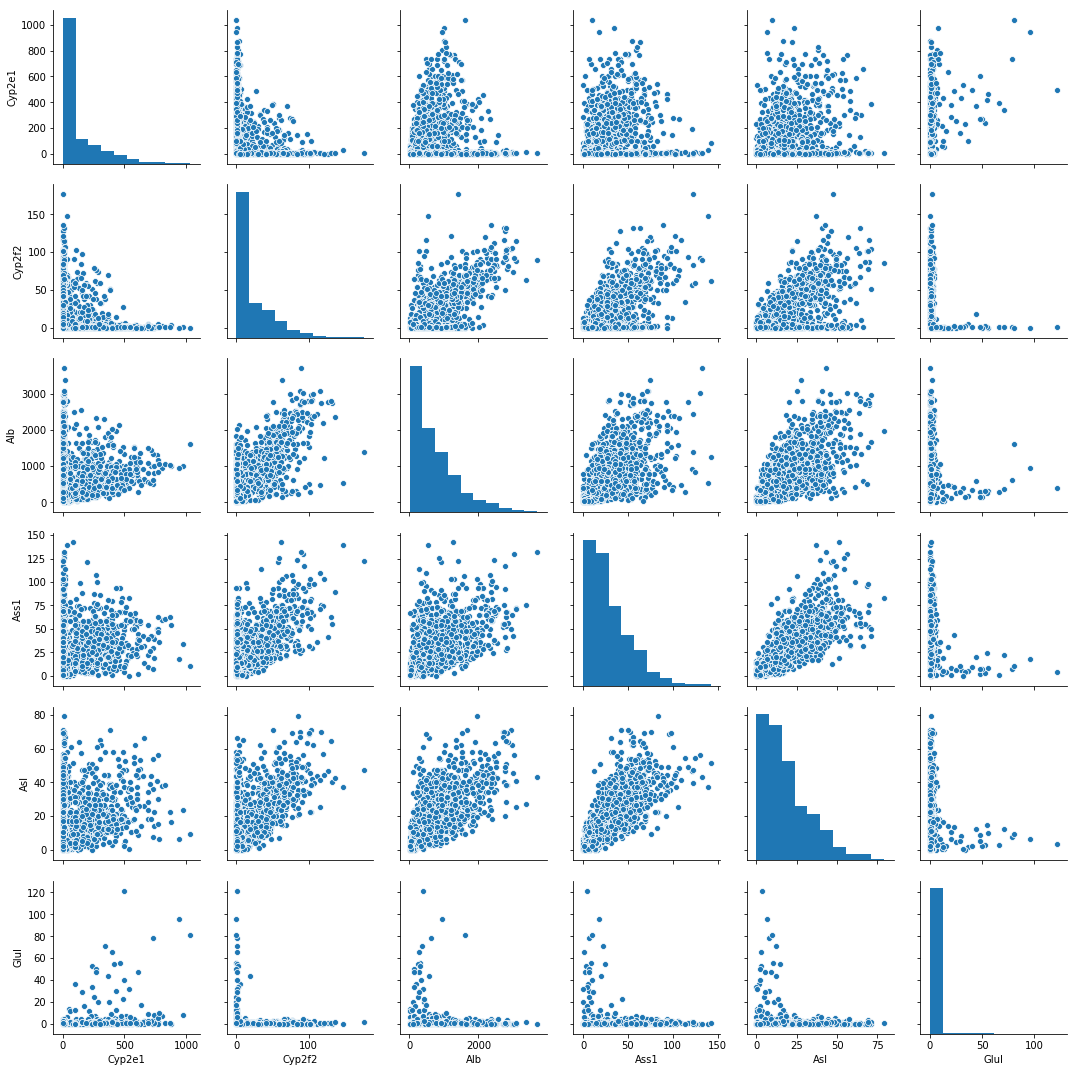

In [26]:
sns.pairplot(pd.DataFrame(adata.raw[:, lm_genes].X, columns=lm_genes), 
             vars=lm_genes)

# Aside: Contrasting Filter

- Scanpy filters genes based on the normalized counts (counts per 10k).
- I'm still not quite sure why using dispersion as a filter is important.
- Here we want to just see what happens when we use their default parameters. 
- After some investigation, it seems like is due to the max_mean=3 (filtering out one gene) and min_disp=0.5 (filtering out 1 gene).
- The point here is that common analysis pipelines require quite a bit of fine tuning, esp. if you want to keep important genes.

filtered out 16998 genes that are detected in less than 10 cells


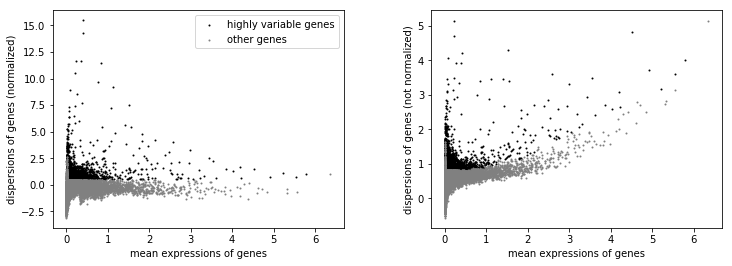

Number of genes kept: 2227


,kept,mean,disper,disper_norm
Alb,False,6.357372,5.146447,1.000000
Asl,False,2.834207,1.337498,-0.177482
Ass1,True,3.312134,2.154075,0.809111
Cyp2e1,True,4.522258,4.810208,1.458676
Cyp2f2,True,2.954954,2.672959,2.026922
Glul,True,0.852509,3.387917,11.435711


In [17]:
adata = load_hepatocyte_data(dat_dir)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)
var_genes_score = {}
lm_gene_score = {}
num_kept_genes = 0
for i, gene_row in enumerate(filter_result):
    gene = adata.var['gene_ids'][i]
    if gene_row[0]:
        var_genes_score[gene] = gene_row
        num_kept_genes += 1
    if gene in lm_genes:
        lm_gene_score[gene] = gene_row
print("Number of genes kept: {}".format(num_kept_genes))        
for lm_gene in lm_gene_score:
    if lm_gene not in adata.var['gene_ids']:
        print("Warning: gene not measured - {}".format(lm_gene))
    if lm_gene not in var_genes_score:
        print("Warning: filtered out - {}".format(lm_gene))
dat_list = list(lm_gene_score.values())
dat_list = [list(d) for d in dat_list]
pd.DataFrame(data=dat_list, index=list(lm_gene_score.keys()), columns=["kept", "mean", "disper", "disper_norm"])

# OLD DEBUG PROCEDURE 

- There are two ways to pre-process the data: keep in counts or use log-transformed data
- There are two ways to construct the graph: exponential distance (w/ w/o knn filtering)
- There are two metrics that can help us: dist_cor (euclidean and gaussian)


Problems with Laplacian score:

- Numerical precision near zero
- Overselecting genes that are expressed in very few of cells (zero-sensitive?)
- The lm genes themselves do not pass the laplacian score test

Problems with distance correlation:

- very sensitive to the scale (selecting genes with high mean), Laplacian is okay.
- the laplacian score seems to be capturing very extermal cases that we don't want
- distance correlation (and perhaps Laplacian score) seems to be sensitive to outlier phenomena

Suggestions:

- proper re-scaling for distance correlation
- handle sparisty problems with laplacian score
- go back to simulations that capture some of this reality
- investigate the scale of dist corr
- filter variable genes 

# TODO: FIX BELOW IF NECESSARY

### Put the score of each gene together in a data frame

In [15]:
from sim_utils import comp_perm_pval

In [16]:
gene_scores = {"mean": adata.X.mean(axis=0), 
               "std": adata.X.std(axis=0),
               "npc": np.sum(adata.X > 0, axis=0)
              }
for score in ["lap_score", "dist_corr"]: 
    sd = feat_perm_scores[score]
    if score == "dist_corr":
        asc = False
    else:
        asc = True
    pvals = comp_perm_pval(sd["feat_scores"], sd["perm_scores"], ascending=asc)
    gene_scores[score + "_pval"] = pvals
    gene_scores[score] = sd["feat_scores"]
gene_scores = pd.DataFrame(gene_scores, index=adata.var_names.tolist())

In [17]:
compare_set = {}
for score in ["lap_score", "dist_corr"]: 
    if score == "lap_score":
        cutoff = np.percentile(feat_perm_scores[score]["perm_scores"], q = 5)
        lap_sel_feat = gene_scores.loc[gene_scores[score] < cutoff]
        lap_sel_feat = lap_sel_feat.sort_values(by="lap_score")        
    else:
        cutoff = np.percentile(feat_perm_scores[score]["perm_scores"], q = 95)
        lap_sel_feat = gene_scores.loc[gene_scores[score] > cutoff]
        lap_sel_feat = lap_sel_feat.sort_values(by="dist_corr", ascending=False)
    lap_sel_feat["rank"] = np.arange(lap_sel_feat.shape[0])
    display(lap_sel_feat.loc[lm_genes])
    display(lap_sel_feat.head(5))
    print("cutoff for {} is at: {}".format(score, cutoff))
    print("selected {} genes".format(lap_sel_feat.shape[0]))
    compare_set[score] = set(lap_sel_feat.index.tolist())
print("Intersect between two approaches: {} genes".format(
       len(compare_set["lap_score"].intersection(compare_set["dist_corr"]))))

,mean,std,npc,lap_score_pval,lap_score,dist_corr_pval,dist_corr,rank
Cyp2e1,3.086100,2.132811,1221,0.0,0.108277,0.0,0.638382,1
Cyp2f2,2.269191,1.415569,1235,0.0,0.088669,0.0,0.596098,0
Alb,6.190163,0.610225,1415,0.0,0.226166,0.0,0.594511,2
Ass1,3.164296,0.588850,1411,0.0,0.410142,0.0,0.475738,6
Asl,2.707551,0.570133,1397,0.0,0.459454,0.0,0.444799,9
Glul,0.347392,0.661617,523,0.0,0.445638,0.0,0.391285,8


,mean,std,npc,lap_score_pval,lap_score,dist_corr_pval,dist_corr,rank
Cyp2f2,2.269191,1.415569,1235,0.0,0.088669,0.0,0.596098,0
Cyp2e1,3.086100,2.132811,1221,0.0,0.108277,0.0,0.638382,1
Alb,6.190163,0.610225,1415,0.0,0.226166,0.0,0.594511,2
Cyp2c29;Cyp2c53-ps,1.253551,1.231416,876,0.0,0.253444,0.0,0.531622,3
Aldh3a2,1.086136,1.036856,901,0.0,0.267996,0.0,0.520295,4


cutoff for lap_score is at: 0.9760728443278246
selected 4086 genes


,mean,std,npc,lap_score_pval,lap_score,dist_corr_pval,dist_corr,rank
Cyp2e1,3.086100,2.132811,1221,0.0,0.108277,0.0,0.638382,0
Cyp2f2,2.269191,1.415569,1235,0.0,0.088669,0.0,0.596098,1
Alb,6.190163,0.610225,1415,0.0,0.226166,0.0,0.594511,2
Ass1,3.164296,0.588850,1411,0.0,0.410142,0.0,0.475738,6
Asl,2.707551,0.570133,1397,0.0,0.459454,0.0,0.444799,9
Glul,0.347392,0.661617,523,0.0,0.445638,0.0,0.391285,16


,mean,std,npc,lap_score_pval,lap_score,dist_corr_pval,dist_corr,rank
Cyp2e1,3.086100,2.132811,1221,0.0,0.108277,0.0,0.638382,0
Cyp2f2,2.269191,1.415569,1235,0.0,0.088669,0.0,0.596098,1
Alb,6.190163,0.610225,1415,0.0,0.226166,0.0,0.594511,2
Cyp2c29;Cyp2c53-ps,1.253551,1.231416,876,0.0,0.253444,0.0,0.531622,3
Cyp1a2,1.778516,1.274644,1144,0.0,0.325154,0.0,0.521436,4


cutoff for dist_corr is at: 0.11008599576826399
selected 6144 genes
Intersect between two approaches: 3440 genes


# Visualization

Projections:
1. UMAP: using all *variable* genes
2. PCA: using only the 6 landmark genes

Genes:
1. genes with top laplacian score
2. genes with top distance correlation
3. landmark genes (reference)

In [34]:
from liver_info import get_projection

def plot_multiple_genes(proj, gene_list):
    num_cols = 6
    num_genes = len(gene_list)
    num_rows = int(np.ceil(num_genes/num_cols))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(3.5*num_cols, 3.4*num_rows-0.8))
    for i, gene in enumerate(gene_list):
        i_row = i // num_cols
        j_col = i % num_cols
        vals = adata[:, gene].X
        if (num_rows == 1):
            ax_i_j =  ax[j_col]  
        else:
            ax_i_j =  ax[i_row][j_col]
        plot_scatter_continuous(proj, vals, ax_i_j)
        ax_i_j.set_title(gene)
full_proj = get_projection("X_umap")
lm_proj = get_projection("X6_pca")[:,:2]
ng_per_grp = 18
# top_genes = gene_scores[gene_scores["lap_score"] > 0.0].sort_values(by="lap_score")
top_ls_genes = gene_scores.sort_values(by="lap_score")
top_ls_genes = top_ls_genes.iloc[:ng_per_grp].index.values
top_dc_genes = gene_scores.sort_values(by="dist_corr", ascending=False).iloc[:ng_per_grp].index.values